In [1]:
%matplotlib ipympl
import os
import pandas as pd
import seaborn as sns
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from skimage.filters import sobel, sobel_h, sobel_v
import ipywidgets as widgets
from ipywidgets import interact
import ipympl
import mpl_interactions.ipyplot as iplt

np.set_printoptions(linewidth=250)
np.set_printoptions(threshold=np.inf)

In [2]:
import sys
sys.executable

'/scicore/home/nimwegen/rocasu25/Documents/Projects/biozentrum/.conda_environment/bin/python'

In [3]:
!jupyter --version
!which jupyterlab

Selected Jupyter core packages...
IPython          : 8.7.0
ipykernel        : 6.15.0
ipywidgets       : 8.0.4
jupyter_client   : 7.4.8
jupyter_core     : 5.1.1
jupyter_server   : 1.23.4
jupyterlab       : 3.3.2
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : not installed
qtconsole        : not installed
traitlets        : 5.7.1
which: no jupyterlab in (/scicore/home/nimwegen/rocasu25/Documents/Projects/biozentrum/.conda_environment/bin:/export/soft/lua_lmod/centos7/lmod/lmod/libexec:/scicore/home/nimwegen/rocasu25/anaconda3/condabin:/export/soft/lua_lmod/centos7/lmod/lmod/libexec:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/ibutils/bin:/scicore/home/nimwegen/rocasu25/bin:/opt/TurboVNC/bin:/scicore/home/nimwegen/rocasu25/bin)


# Opening a single cell mask image

(881, 2, 350, 107)


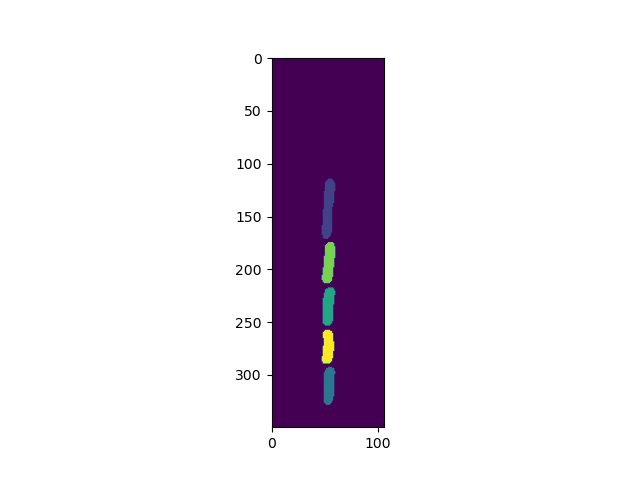

(881, 2, 350, 107)


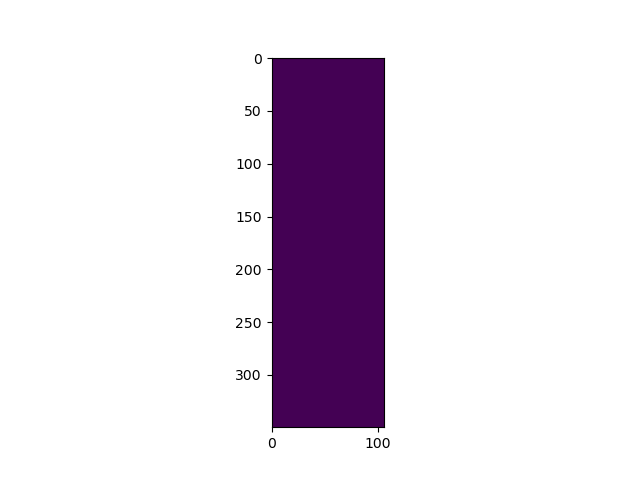

(881, 350, 107, 3)


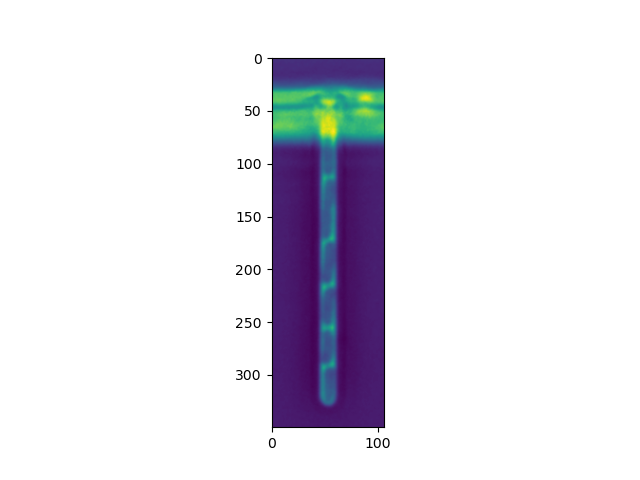

In [3]:
image_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos0/Pos0_GL17/moma_batch_hi1/export_data__moma_batch_hi1/CellMasks__20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos0_GL17.tif"
im = io.imread(image_path)
print(im.shape)
plt.imshow(im[0,0,:,:])
plt.show()

image_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos0/Pos0_GL17/moma_batch_hi1/export_data__moma_batch_hi1/CellMasks__20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos0_GL17.tif"
im = io.imread(image_path)
print(im.shape)
plt.imshow(im[0,1,:,:])
plt.show()

image_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos0/Pos0_GL17/20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos0_GL17.tif"
im = io.imread(image_path)
print(im.shape)
plt.imshow(im[0,:,:,0])
plt.show()

# Function to plot profile of a given root cell from a given CellMasks file

## Documentation

- Inputs are cell mask path and fluorescence image path
- First the root cell mask is computed (compute_root_cell_masks).
- The most bottom pixel of the image belonging to a cell (the root cell), is used to select the root cell mask (used as a seed to flood fill the mask).
- Output is a list of cell masks of root cells, for all frames in that GL.
- It is then used to compute on the fluorescence image
  - The mean fluorescence value across all pixels
  - This is used to compute the normalized fluorescence value for each pixel belonging to the cell
  - Then, the mean normalized fluorescence is computed over all pixels per row: this is what I call "profile"
  - This profile is reversed, from bottom to top and nan are added so that these different vectors have the same size

In [364]:
from skimage.segmentation import flood, flood_fill


def frame_number(cell_mask_path):
    cell_mask=io.imread(cell_mask_path)
    frame_number=int(cell_mask.shape[0]/2)
    return frame_number
    
def compute_root_cell_masks(cell_mask_path,example_frame=0,plot=False):
    cell_masks=io.imread(cell_mask_path)
    #gl_images=io.imread(growth_lane_tif_path)
    
    if plot==True:
    #display cell mask at selected example frame
        plt.imshow(cell_mask[example_frame,0,:,:])
        plt.show()

    #compute the root cell mask
    ## for each frame, compute see coordinates
    binary_masks=cell_masks[:,0,:,:]
    binary_masks=(binary_masks>0)*1
    binary_masks_reversed=cell_masks[:,0,::-1,:]
    binary_masks_reversed=(binary_masks_reversed>0)*1
    first_pixel=binary_masks_reversed.reshape(binary_masks_reversed.shape[0],1,binary_masks_reversed.shape[1]*binary_masks_reversed.shape[2])
    first_pixel_x=np.argmax(first_pixel>0,axis=2)/cell_masks.shape[3]
    first_pixel_x=np.trunc(np.ones(first_pixel_x.shape)*cell_masks.shape[2]-first_pixel_x)
    first_pixel_y=(np.argmax(first_pixel>0,axis=2)+1)%cell_masks.shape[3]-1
    first_pixel_x=first_pixel_x.flatten().tolist()
    first_pixel_y=first_pixel_y.flatten().tolist()
    first_pixel_x=[int(e) for e in first_pixel_x]
    first_pixel_y=[int(e) for e in first_pixel_y]
    first_pixels=[e for e in zip(first_pixel_x,first_pixel_y)]
    
    ## Flood fill using see coordinates
    root_cell_masks = [binary_masks[i,:,:] for i in range(0,binary_masks.shape[0])]
    root_cell_masks=[flood_fill(root_cell_masks[i],first_pixels[i],2,in_place=False,connectivity=1) for i in range(0,len(root_cell_masks))] #0: no cell, 1: cell 2: root cell]
    root_cell_masks=np.array(root_cell_masks)
    root_cell_masks=np.where(root_cell_masks==2,1,0)
    return (root_cell_masks)

def compute_root_cell_masks_list_input(cell_mask_path,cell_id_df,example_frame=0,plot=False):
    cell_masks=io.imread(cell_mask_path)
    #gl_images=io.imread(growth_lane_tif_path)
    
    if plot==True:
    #display cell mask at selected example frame
        plt.imshow(cell_mask[example_frame,0,:,:])
        plt.show()

    #compute the root cell mask
    ## for each frame, compute see coordinates
    #binary_masks=cell_masks[:,0,:,:]
    #binary_masks=(binary_masks>0)*1
    #binary_masks_reversed=cell_masks[:,0,::-1,:]
    #binary_masks_reversed=(binary_masks_reversed>0)*1
    #first_pixel=binary_masks_reversed.reshape(binary_masks_reversed.shape[0],1,binary_masks_reversed.shape[1]*binary_masks_reversed.shape[2])
    #first_pixel_x=np.argmax(first_pixel>0,axis=2)/cell_masks.shape[3]
    #first_pixel_x=np.trunc(np.ones(first_pixel_x.shape)*cell_masks.shape[2]-first_pixel_x)
    #first_pixel_y=(np.argmax(first_pixel>0,axis=2)+1)%cell_masks.shape[3]-1
    #first_pixel_x=first_pixel_x.flatten().tolist()
    #first_pixel_y=first_pixel_y.flatten().tolist()
    #first_pixel_x=[int(e) for e in first_pixel_x]
    #first_pixel_y=[int(e) for e in first_pixel_y]
    #first_pixels=[e for e in zip(first_pixel_x,first_pixel_y)]
    
    ## Flood fill using see coordinates
    root_cell_masks = [cell_masks[i,0,:,:] for i in range(0,cell_masks.shape[0])]
    cell_ids=np.array(cell_id_df)[:,0]
    indices=np.array(cell_id_df)[:,1]
    cell_ids_dic={i:c for i,c in zip(indices,cell_ids)}
    root_cell_masks= [np.where(root_cell_masks[i]==cell_ids_dic[i],1,0) if i in indices else root_cell_masks[i]*0 for i in range(0,len(root_cell_masks))]
    root_cell_masks=np.array(root_cell_masks)
    #root_cell_masks = [binary_masks[i,:,:] for i in range(0,binary_masks.shape[0])]
    #root_cell_masks=[flood_fill(root_cell_masks[i],first_pixels[i],2,in_place=False,connectivity=1) for i in range(0,len(root_cell_masks))] #0: no cell, 1: cell 2: root cell]
    #root_cell_masks=np.array(root_cell_masks)
    #root_cell_masks=np.where(root_cell_masks==2,1,0)
    return (root_cell_masks)

def compute_profiles(root_cell_masks,growth_lane_tif_path):
    gl_images=io.imread(growth_lane_tif_path)[:,:,:,2]
    gl_images=np.where(root_cell_masks==1,gl_images,0)
    fluo_means=np.mean(gl_images,axis=(1,2),where=root_cell_masks==1)
    fluo_means_reshaped=np.repeat(fluo_means,gl_images.shape[1]*gl_images.shape[2])
    fluo_means_reshaped=np.reshape(fluo_means_reshaped,(fluo_means.shape[0],gl_images.shape[1],gl_images.shape[2]))
    fluo_norm=np.divide(gl_images,fluo_means_reshaped)
    fluo_profile=np.mean(fluo_norm,axis=2,where=root_cell_masks==1)
    fluo_profile=[fluo_profile[i,:] for i in range(fluo_profile.shape[0])]
    fluo_profile=[x[~np.isnan(x)] for x in fluo_profile]
    return(fluo_profile)

def treat_profiles(cell_mask_tif_path,growth_lane_tif_path):
    root_cell_masks=compute_root_cell_masks(cell_mask_tif_path,growth_lane_tif_path,frame_number(cell_mask_tif_path))
    profiles=compute_profiles(root_cell_masks,growth_lane_tif_path)
    profiles=[e[::-1] for e in profiles]
    len_list=[len(e) for e in profiles]
    max_length=np.max(len_list)
    missing_zeros=[(max_length-e.shape[0]) for e in profiles]
    missing_zeros=[np.empty(z)*np.nan for z in missing_zeros]
    profiles=[np.concatenate((e,z)) for e,z in zip(profiles, missing_zeros)]
    profiles=np.array(profiles)
    return(profiles)

def treat_profiles_list_input(cell_mask_tif_path,growth_lane_tif_path,cell_id_df):
    root_cell_masks=compute_root_cell_masks_list_input(cell_mask_tif_path,cell_id_df,frame_number(cell_mask_tif_path))
    profiles=compute_profiles(root_cell_masks,growth_lane_tif_path)
    profiles=[e[::-1] for e in profiles]
    len_list=[len(e) for e in profiles]
    max_length=np.max(len_list)
    missing_zeros=[(max_length-e.shape[0]) for e in profiles]
    missing_zeros=[np.empty(z)*np.nan for z in missing_zeros]
    profiles=[np.concatenate((e,z)) for e,z in zip(profiles, missing_zeros)]
    profiles=np.array(profiles)
    return(profiles)

In [365]:
a=compute_root_cell_masks_list_input(cell_mask_tif_path_1,cell_id_df_1)
a.shape

(881, 350, 107)

# Analyze profile in glycerol, pos0, gl17, r0

## What is the mean profile?

In [ ]:
cell_mask_tif_path_1="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos0/Pos0_GL17/moma_batch_hi1/export_data__moma_batch_hi1/CellMasks__20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos0_GL17.tif"
growth_lane_tif_path_1="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos0/Pos0_GL17/20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos0_GL17.tif"
example_frame_1=710
profiles=treat_profiles(cell_mask_tif_path_1,growth_lane_tif_path_1)

In [ ]:
profiles_gly=profiles[460:880,:]
profiles_mean_gly=np.mean(profiles_gly,axis=0)
profiles_std_gly=np.std(profiles_gly,axis=0)

profiles_glu=profiles[40:440,:]
profiles_mean_glu=np.mean(profiles_glu,axis=0)
profiles_std_glu=np.std(profiles_glu,axis=0)

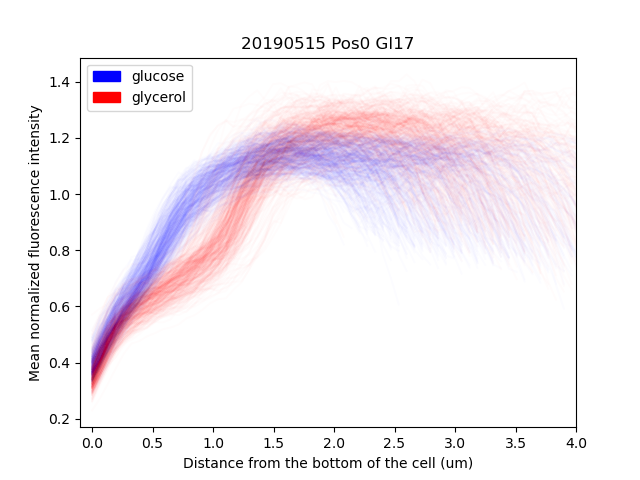

In [ ]:
%matplotlib ipympl
%matplotlib ipympl
import matplotlib.patches as mpatches

gly_patch=mpatches.Patch(color='red',label='glycerol')
glu_patch=mpatches.Patch(color='blue',label='glucose')

ranges=list(range(40,440))+list(range(460,880))
colours=['blue']*(440-40)+['red']*(880-460)
labels=['glucose']*(440-40)+['glycerol']*(880-460)
x=np.arange(0,len(profiles[0,:]))*0.065

for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colours[k],alpha=0.01)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.legend(handles=[glu_patch,gly_patch])
plt.xlim(-0.1,4)
plt.title('20190515 Pos0 Gl17')
plt.savefig("./all_frames_pos0_gl17.pdf",dpi=200)

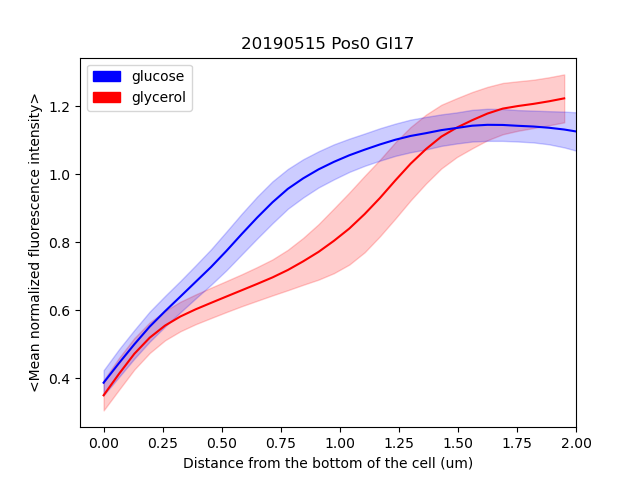

In [240]:
%matplotlib ipympl
%matplotlib ipympl

gly_patch=mpatches.Patch(color='red',label='glycerol')
glu_patch=mpatches.Patch(color='blue',label='glucose')

x_gly=np.arange(0,len(profiles_mean_gly))*0.065
x_glu=np.arange(0,len(profiles_mean_glu))*0.065
plt.plot(x_gly,profiles_mean_gly,color="red")
plt.plot(x_glu,profiles_mean_glu,color="blue")
plt.fill_between(x_gly,profiles_mean_gly+profiles_std_gly,profiles_mean_gly-profiles_std_gly,color="red",alpha=0.2)
plt.fill_between(x_glu,profiles_mean_glu+profiles_std_glu,profiles_mean_glu-profiles_std_glu,color="blue",alpha=0.2)
plt.legend(handles=[glu_patch,gly_patch])
plt.ylabel("<Mean normalized fluorescence intensity>")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)
plt.title('20190515 Pos0 Gl17')
plt.savefig("./mean_all_frames_pos0_gl17.pdf",dpi=200)

## Is it something that gets worse over generations?

(-0.1, 4.0)

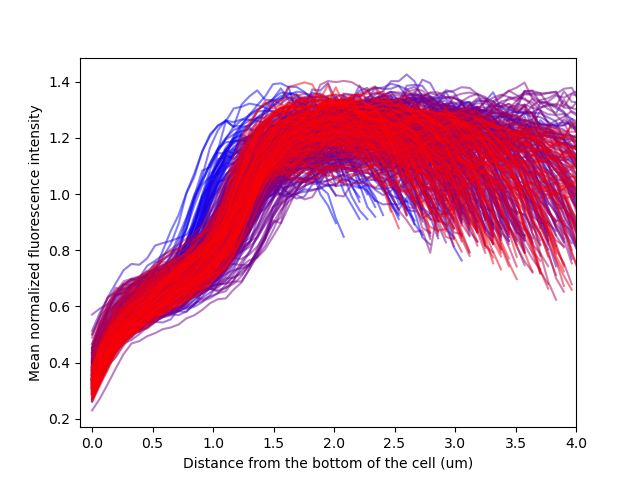

In [ ]:
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl

def colorFader(c1,c2,mix=0):
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return(mpl.colors.to_hex((1-mix)*c1+mix*c2))

c1='blue'
c2='red'

ranges=list(range(460,880))
n=len(ranges)
x=np.arange(0,len(profiles[0,:]))*0.065

for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colorFader(c1,c2,k/n),alpha=0.5)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)

(-0.1, 4.0)

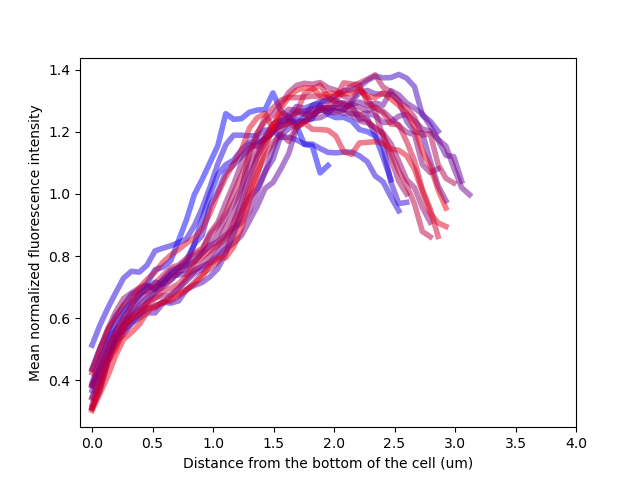

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?

%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl

def colorFader(c1,c2,mix=0):
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return(mpl.colors.to_hex((1-mix)*c1+mix*c2))

c1='blue'
c2='red'

#ranges=list(range(460,880))
ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]

n=len(ranges)
x=np.arange(0,len(profiles[0,:]))*0.065

#fig,ax=plt.subplots(1,len(ranges))
for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colorFader(c1,c2,k/n),alpha=0.5,linewidth=4)
    #ax[k].plot(x,profiles[i],alpha=1)
    #ax[k].set_ylim(-0.1,2)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)


(0.2, 1.5)

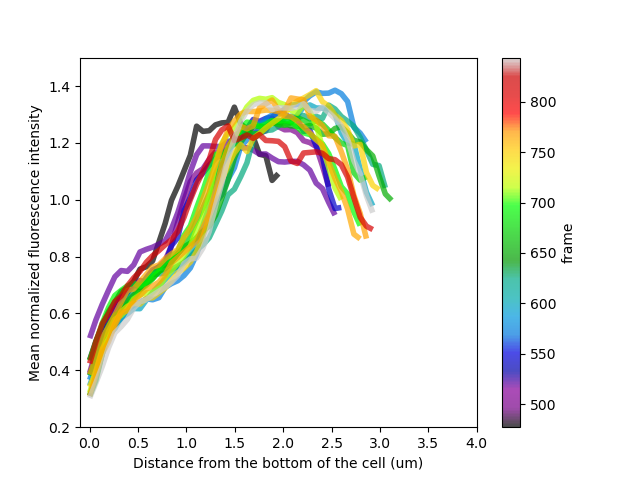

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl
from matplotlib.collections import LineCollection

x=np.arange(0,len(profiles[0,:]))*0.065
profiles_plot=[np.column_stack([x,profiles[i,:]]) for i in range(0,profiles.shape[0])]

#ranges=list(range(460,880))
ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]
profiles_plot=[profiles_plot[i] for i in ranges]

fig,ax=plt.subplots()
lc=LineCollection(profiles_plot,cmap='nipy_spectral',array=ranges,linewidth=4,alpha=0.7)
line=ax.add_collection(lc)
fig.colorbar(line,label='frame')
ax.set_ylabel("Mean normalized fluorescence intensity")
ax.set_xlabel("Distance from the bottom of the cell (um)")
ax.set_xlim(-0.1,4)
ax.set_ylim(0.2,1.5)


(0.2, 1.5)

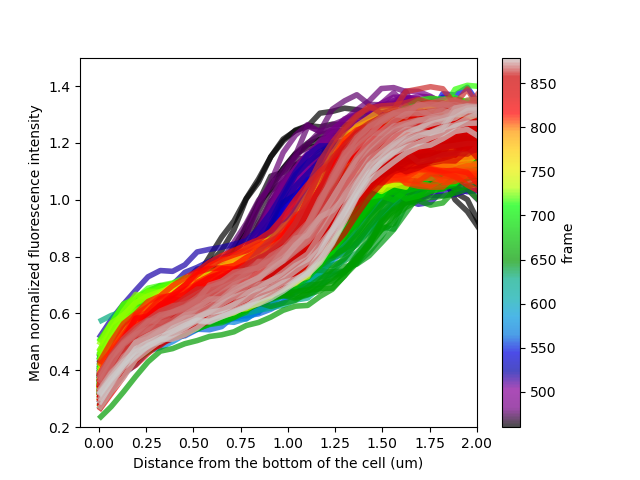

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl
from matplotlib.collections import LineCollection

x=np.arange(0,len(profiles[0,:]))*0.065
profiles_plot=[np.column_stack([x,profiles[i,:]]) for i in range(0,profiles.shape[0])]

#ranges=list(range(460,880))
#ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]
ranges=list(np.arange(460,880))
profiles_plot=[profiles_plot[i] for i in ranges]

fig,ax=plt.subplots()
lc=LineCollection(profiles_plot,cmap='nipy_spectral',array=ranges,linewidth=4,alpha=0.7)
line=ax.add_collection(lc)
fig.colorbar(line,label='frame')
ax.set_ylabel("Mean normalized fluorescence intensity")
ax.set_xlabel("Distance from the bottom of the cell (um)")
ax.set_xlim(-0.1,2)
ax.set_ylim(0.2,1.5)


# Analyze profile in glycerol, pos0, gl17, r1

## What is the mean profile?

In [368]:
cell_mask_tif_path_1="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos0/Pos0_GL17/moma_batch_hi1/export_data__moma_batch_hi1/CellMasks__20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos0_GL17.tif"
growth_lane_tif_path_1="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos0/Pos0_GL17/20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos0_GL17.tif"
cell_id_df_1=pd.read_csv("./cell_to_find_r1_pos0_gl17.csv")
example_frame_1=710
profiles=treat_profiles_list_input(cell_mask_tif_path_1,growth_lane_tif_path_1,cell_id_df_1)

/scicore/home/nimwegen/rocasu25/Documents/Projects/biozentrum/.conda_environment/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scicore/home/nimwegen/rocasu25/Documents/Projects/biozentrum/.conda_environment/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


array([0.89234197, 0.94747841, 0.99996424, 0.99986851, 1.0512569 , 1.08285165, 1.10094547, 1.112499  , 1.11104286, 1.10162592, 1.08784115, 1.08310556, 1.07360315, 1.06796241, 1.01260269, 1.00721145, 0.98044348, 0.94248712, 0.89403534, 0.8420046 ,
       0.82885098, 0.74305433, 0.72127485,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,        nan,
            

In [369]:
profiles_gly=profiles[460:880,:]
profiles_mean_gly=np.mean(profiles_gly,axis=0)
profiles_std_gly=np.std(profiles_gly,axis=0)

profiles_glu=profiles[40:440,:]
profiles_mean_glu=np.mean(profiles_glu,axis=0)
profiles_std_glu=np.std(profiles_glu,axis=0)

In [370]:
%matplotlib ipympl
%matplotlib ipympl
import matplotlib.patches as mpatches

gly_patch=mpatches.Patch(color='red',label='glycerol')
glu_patch=mpatches.Patch(color='blue',label='glucose')

ranges=list(range(40,440))+list(range(460,880))
colours=['blue']*(440-40)+['red']*(880-460)
labels=['glucose']*(440-40)+['glycerol']*(880-460)
x=np.arange(0,len(profiles[0,:]))*0.065

for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colours[k],alpha=0.01)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.legend(handles=[glu_patch,gly_patch])
plt.xlim(-0.1,4)
plt.title('20190515 Pos0 Gl17 R1 cells')
plt.savefig("./all_frames_pos0_gl17_r1_cells.pdf",dpi=200)

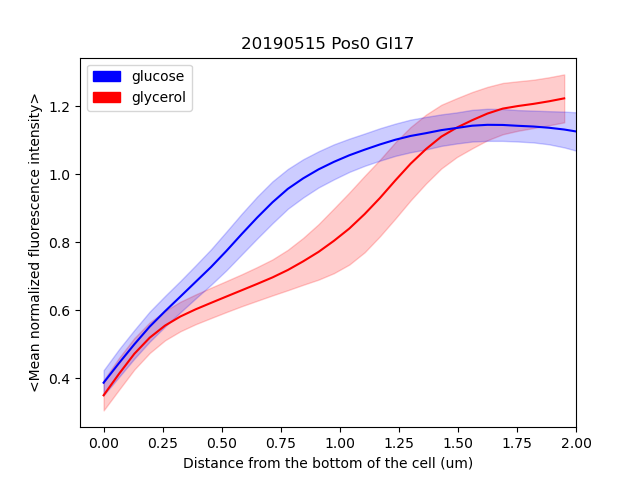

In [240]:
%matplotlib ipympl
%matplotlib ipympl

gly_patch=mpatches.Patch(color='red',label='glycerol')
glu_patch=mpatches.Patch(color='blue',label='glucose')

x_gly=np.arange(0,len(profiles_mean_gly))*0.065
x_glu=np.arange(0,len(profiles_mean_glu))*0.065
plt.plot(x_gly,profiles_mean_gly,color="red")
plt.plot(x_glu,profiles_mean_glu,color="blue")
plt.fill_between(x_gly,profiles_mean_gly+profiles_std_gly,profiles_mean_gly-profiles_std_gly,color="red",alpha=0.2)
plt.fill_between(x_glu,profiles_mean_glu+profiles_std_glu,profiles_mean_glu-profiles_std_glu,color="blue",alpha=0.2)
plt.legend(handles=[glu_patch,gly_patch])
plt.ylabel("<Mean normalized fluorescence intensity>")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)
plt.title('20190515 Pos0 Gl17')
plt.savefig("./mean_all_frames_pos0_gl17.pdf",dpi=200)

## Is it something that gets worse over generations?

(-0.1, 4.0)

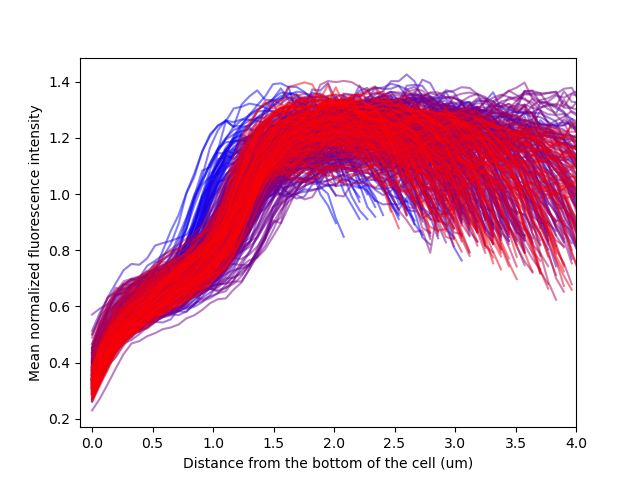

In [ ]:
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl

def colorFader(c1,c2,mix=0):
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return(mpl.colors.to_hex((1-mix)*c1+mix*c2))

c1='blue'
c2='red'

ranges=list(range(460,880))
n=len(ranges)
x=np.arange(0,len(profiles[0,:]))*0.065

for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colorFader(c1,c2,k/n),alpha=0.5)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)

(-0.1, 4.0)

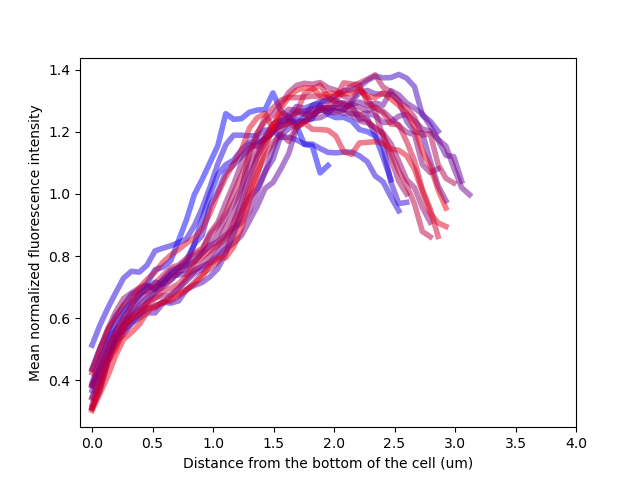

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?

%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl

def colorFader(c1,c2,mix=0):
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return(mpl.colors.to_hex((1-mix)*c1+mix*c2))

c1='blue'
c2='red'

#ranges=list(range(460,880))
ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]

n=len(ranges)
x=np.arange(0,len(profiles[0,:]))*0.065

#fig,ax=plt.subplots(1,len(ranges))
for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colorFader(c1,c2,k/n),alpha=0.5,linewidth=4)
    #ax[k].plot(x,profiles[i],alpha=1)
    #ax[k].set_ylim(-0.1,2)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)


(0.2, 1.5)

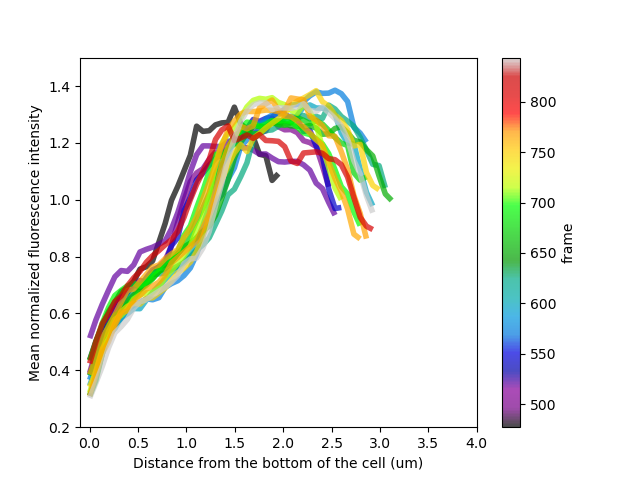

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl
from matplotlib.collections import LineCollection

x=np.arange(0,len(profiles[0,:]))*0.065
profiles_plot=[np.column_stack([x,profiles[i,:]]) for i in range(0,profiles.shape[0])]

#ranges=list(range(460,880))
ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]
profiles_plot=[profiles_plot[i] for i in ranges]

fig,ax=plt.subplots()
lc=LineCollection(profiles_plot,cmap='nipy_spectral',array=ranges,linewidth=4,alpha=0.7)
line=ax.add_collection(lc)
fig.colorbar(line,label='frame')
ax.set_ylabel("Mean normalized fluorescence intensity")
ax.set_xlabel("Distance from the bottom of the cell (um)")
ax.set_xlim(-0.1,4)
ax.set_ylim(0.2,1.5)


(0.2, 1.5)

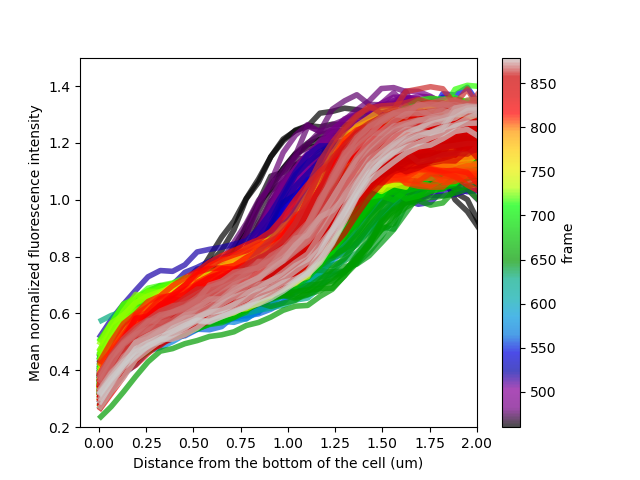

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl
from matplotlib.collections import LineCollection

x=np.arange(0,len(profiles[0,:]))*0.065
profiles_plot=[np.column_stack([x,profiles[i,:]]) for i in range(0,profiles.shape[0])]

#ranges=list(range(460,880))
#ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]
ranges=list(np.arange(460,880))
profiles_plot=[profiles_plot[i] for i in ranges]

fig,ax=plt.subplots()
lc=LineCollection(profiles_plot,cmap='nipy_spectral',array=ranges,linewidth=4,alpha=0.7)
line=ax.add_collection(lc)
fig.colorbar(line,label='frame')
ax.set_ylabel("Mean normalized fluorescence intensity")
ax.set_xlabel("Distance from the bottom of the cell (um)")
ax.set_xlim(-0.1,2)
ax.set_ylim(0.2,1.5)


interactive(children=(IntSlider(value=7, description='Browse through frames:', max=880), Output()), _dom_class…

<function __main__.plot_test(i)>

# Analyze profile in glycerol, pos4, gl2, r0

## What is the mean profile?

In [374]:
cell_mask_tif_path_1="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos1/Pos1_GL6/moma_batch_hi1/export_data__moma_batch_hi1/CellMasks__20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos1_GL6.tif"
growth_lane_tif_path_1="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20190515/20190515_preproc_right_bis/Pos1/Pos1_GL6/20190515_hi1_med1_med2_rpmB_glu_gly_7_MMStack_Pos1_GL6.tif"
cell_id_df_1=pd.read_csv("./cell_to_find_r0_pos1_gl6.csv")
example_frame_1=710
profiles=treat_profiles_list_input(cell_mask_tif_path_1,growth_lane_tif_path_1,cell_id_df_1)

/scicore/home/nimwegen/rocasu25/Documents/Projects/biozentrum/.conda_environment/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scicore/home/nimwegen/rocasu25/Documents/Projects/biozentrum/.conda_environment/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [375]:
profiles_gly=profiles[460:880,:]
profiles_mean_gly=np.mean(profiles_gly,axis=0)
profiles_std_gly=np.std(profiles_gly,axis=0)

profiles_glu=profiles[40:440,:]
profiles_mean_glu=np.mean(profiles_glu,axis=0)
profiles_std_glu=np.std(profiles_glu,axis=0)

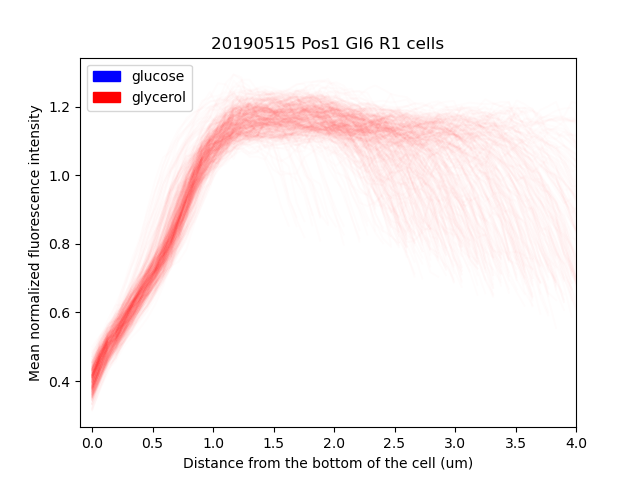

In [377]:
%matplotlib ipympl
%matplotlib ipympl
import matplotlib.patches as mpatches

gly_patch=mpatches.Patch(color='red',label='glycerol')
glu_patch=mpatches.Patch(color='blue',label='glucose')

ranges=list(range(40,440))+list(range(460,880))
colours=['blue']*(440-40)+['red']*(880-460)
labels=['glucose']*(440-40)+['glycerol']*(880-460)
x=np.arange(0,len(profiles[0,:]))*0.065

for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colours[k],alpha=0.01)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.legend(handles=[glu_patch,gly_patch])
plt.xlim(-0.1,4)
plt.title('20190515 Pos1 Gl6 R1 cells')
plt.savefig("./all_frames_pos1_gl6_r0_cells.pdf",dpi=200)

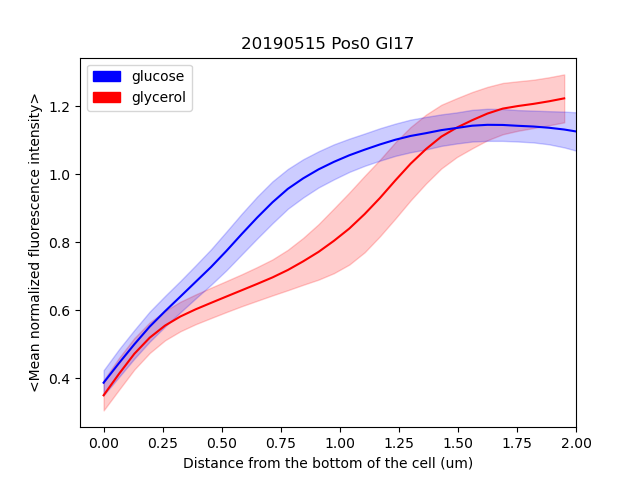

In [240]:
%matplotlib ipympl
%matplotlib ipympl

gly_patch=mpatches.Patch(color='red',label='glycerol')
glu_patch=mpatches.Patch(color='blue',label='glucose')

x_gly=np.arange(0,len(profiles_mean_gly))*0.065
x_glu=np.arange(0,len(profiles_mean_glu))*0.065
plt.plot(x_gly,profiles_mean_gly,color="red")
plt.plot(x_glu,profiles_mean_glu,color="blue")
plt.fill_between(x_gly,profiles_mean_gly+profiles_std_gly,profiles_mean_gly-profiles_std_gly,color="red",alpha=0.2)
plt.fill_between(x_glu,profiles_mean_glu+profiles_std_glu,profiles_mean_glu-profiles_std_glu,color="blue",alpha=0.2)
plt.legend(handles=[glu_patch,gly_patch])
plt.ylabel("<Mean normalized fluorescence intensity>")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)
plt.title('20190515 Pos0 Gl17')
plt.savefig("./mean_all_frames_pos0_gl17.pdf",dpi=200)

## Is it something that gets worse over generations?

(-0.1, 4.0)

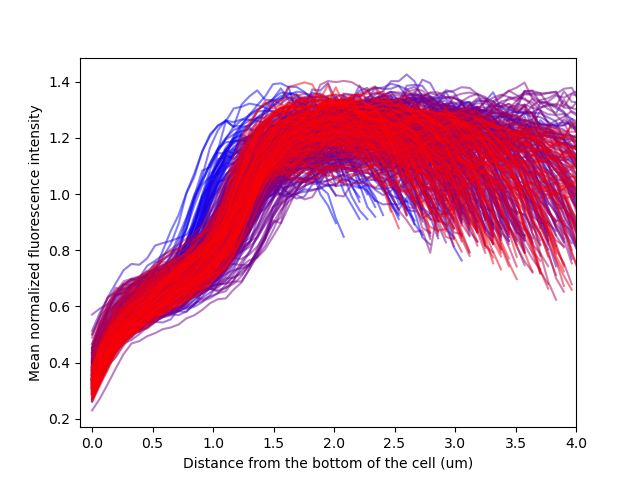

In [ ]:
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl

def colorFader(c1,c2,mix=0):
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return(mpl.colors.to_hex((1-mix)*c1+mix*c2))

c1='blue'
c2='red'

ranges=list(range(460,880))
n=len(ranges)
x=np.arange(0,len(profiles[0,:]))*0.065

for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colorFader(c1,c2,k/n),alpha=0.5)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)

(-0.1, 4.0)

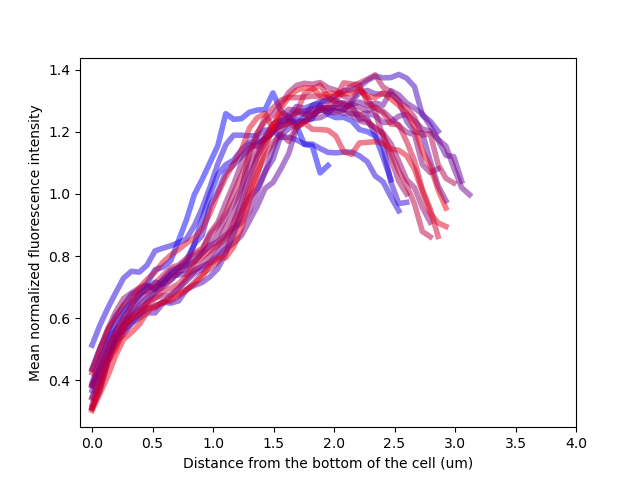

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?

%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl

def colorFader(c1,c2,mix=0):
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return(mpl.colors.to_hex((1-mix)*c1+mix*c2))

c1='blue'
c2='red'

#ranges=list(range(460,880))
ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]

n=len(ranges)
x=np.arange(0,len(profiles[0,:]))*0.065

#fig,ax=plt.subplots(1,len(ranges))
for i,k in zip(ranges,range(0,len(ranges))):
    plt.plot(x,profiles[i],color=colorFader(c1,c2,k/n),alpha=0.5,linewidth=4)
    #ax[k].plot(x,profiles[i],alpha=1)
    #ax[k].set_ylim(-0.1,2)
    #plt.fill_between(x,profiles_mean+profiles_std,profiles_mean-profiles_std,color="gray",alpha=0.2)
plt.ylabel("Mean normalized fluorescence intensity")
plt.xlabel("Distance from the bottom of the cell (um)")
plt.xlim(-0.1,4)


(0.2, 1.5)

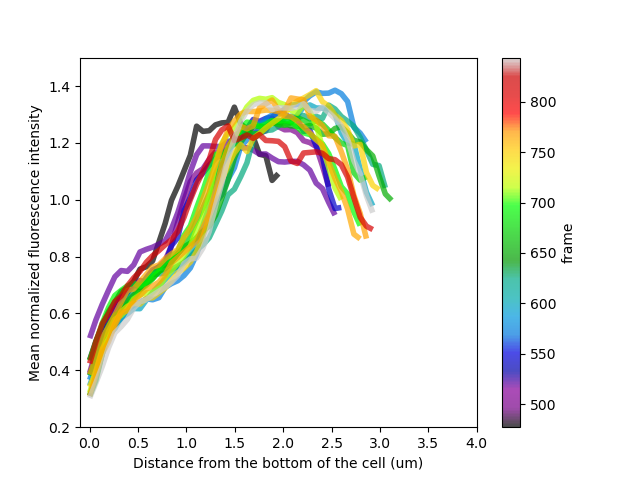

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl
from matplotlib.collections import LineCollection

x=np.arange(0,len(profiles[0,:]))*0.065
profiles_plot=[np.column_stack([x,profiles[i,:]]) for i in range(0,profiles.shape[0])]

#ranges=list(range(460,880))
ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]
profiles_plot=[profiles_plot[i] for i in ranges]

fig,ax=plt.subplots()
lc=LineCollection(profiles_plot,cmap='nipy_spectral',array=ranges,linewidth=4,alpha=0.7)
line=ax.add_collection(lc)
fig.colorbar(line,label='frame')
ax.set_ylabel("Mean normalized fluorescence intensity")
ax.set_xlabel("Distance from the bottom of the cell (um)")
ax.set_xlim(-0.1,4)
ax.set_ylim(0.2,1.5)


(0.2, 1.5)

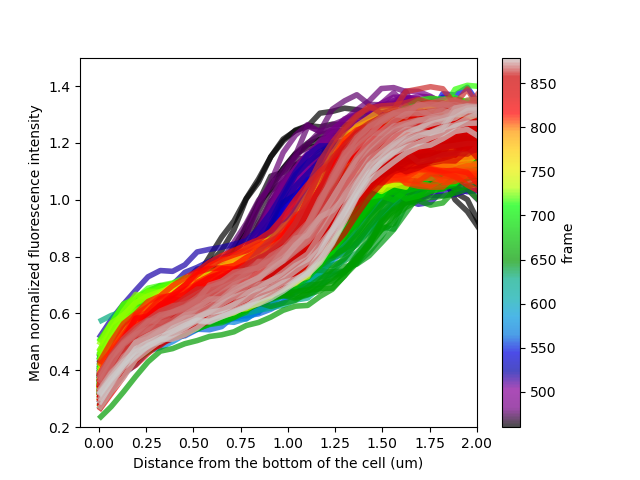

In [ ]:
#what if we look at this, one time per cell cycle?
#what frames?
%matplotlib ipympl
%matplotlib ipympl
import matplotlib as mpl
from matplotlib.collections import LineCollection

x=np.arange(0,len(profiles[0,:]))*0.065
profiles_plot=[np.column_stack([x,profiles[i,:]]) for i in range(0,profiles.shape[0])]

#ranges=list(range(460,880))
#ranges=[477,502,520,543,573,598,626,653,672,696,714,748,765,767,813,844]
ranges=list(np.arange(460,880))
profiles_plot=[profiles_plot[i] for i in ranges]

fig,ax=plt.subplots()
lc=LineCollection(profiles_plot,cmap='nipy_spectral',array=ranges,linewidth=4,alpha=0.7)
line=ax.add_collection(lc)
fig.colorbar(line,label='frame')
ax.set_ylabel("Mean normalized fluorescence intensity")
ax.set_xlabel("Distance from the bottom of the cell (um)")
ax.set_xlim(-0.1,2)
ax.set_ylim(0.2,1.5)


interactive(children=(IntSlider(value=7, description='Browse through frames:', max=880), Output()), _dom_class…

<function __main__.plot_test(i)>

In [228]:
%matplotlib ipympl
%matplotlib ipympl

fig,ax=plt.subplots()

import mpl_interactions.ipyplot as iplt

def plot(i):
    return(profiles[i])

i=np.arange(0,880)
#fig, ax=plt.subplots()
ctrls=iplt.plot(plot,i=i)

# What is the best to show

We would like a representative idea of how the cells are behaving. In different media.
But right now, I focused on the worst case scenario: id est, I selected based on my analysis gl, which are characterized by large assymetry of concentration at division.
So I should simply plot, for these, how the fluorescence vary together with the length of the cell.
I can show plots for gl that do display strong differences, and plots for cells that do not show any.




